In [1]:
import os
import geopandas as gpd
import rasterio.plot
from rasterstats import zonal_stats
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Pollution Raster (NO2 Concentration)

I chose NO2 (Nitrogen Dioxide) as the pollution metric  because it is a widely-used indicator of air quality in urban environments. NO2 is produced by vehicle emissions and industrial activity, and elevated levels have been linked to respiratory issues, especially in children. The raster dataset represents annual average concentrations of NO2 across NYC at a 300-meter resolution. The data url is https://data.cityofnewyork.us/Environment/NYCCAS-Air-Pollution-Rasters/q68s-8qxv/about_data.

In [2]:
pollution_tile_path = '../Data/AnnAvg_1_15_300m/aa1_no2300m'
with rasterio.open(pollution_tile_path) as src:
    raster_crs = src.crs
    raster_transform = src.transform
    raster_path_full = src.name

## School Locations (Point Data)

I fetched the points of public schools in NYC to explore how air quality varies across the educational landscape. Schools were selected as critical points of interest due to the vulnerability of children to air pollution and the broader implications for health equity and educational fairness. The data url is https://data.cityofnewyork.us/Education/School-Point-Locations/jfju-ynrr/about_data

In [3]:
school_zip_path = '../Data/SchoolPoints_APS_2024_08_28'
for file in os.listdir(school_zip_path):
    if file.endswith(".shp"):
        school_gdf = gpd.read_file(os.path.join(school_zip_path, file))
        break

## Buffer Zone Analysis (300m radius)

For each school, I computed the average NO2 level within a 300-meter (~3 city blocks) buffer to reflect the immediate environment that students experience on a daily basis (including their commute, outdoor play, etc.).

Here I got the following primary conclusions:
- The histogram shows that most NYC public schools are surrounded by moderate NO2 levels, typically in the range of 24–30 units.
- A right-skewed tail indicates that while most schools fall within a central pollution band, there are outliers with significantly higher NO2 exposure, reaching levels above 40.


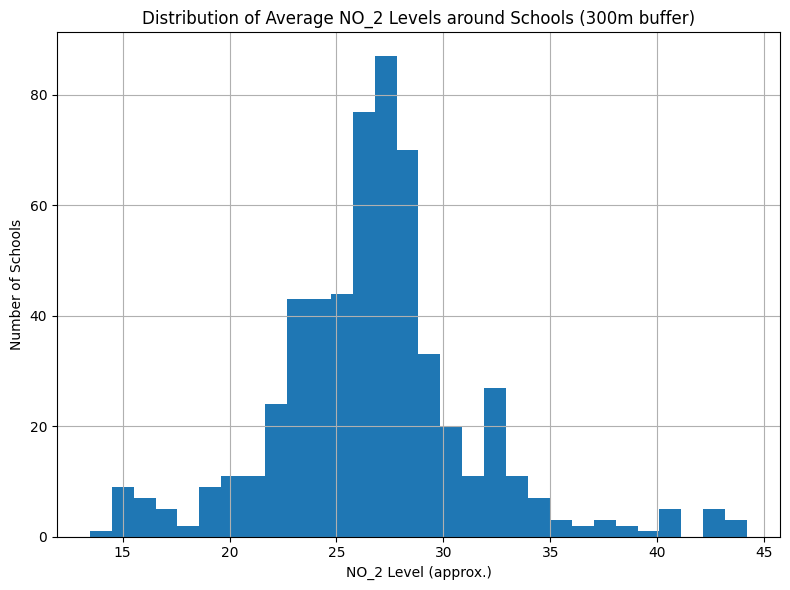

In [4]:
school_gdf = school_gdf.to_crs(raster_crs)
buffer_radius = 300
school_gdf['geometry_buffer'] = school_gdf.buffer(buffer_radius)
buffer_stats = zonal_stats(
    vectors=school_gdf['geometry_buffer'],
    raster=raster_path_full,
    stats=["mean"],
    nodata=-9999,
    geojson_out=False
)
school_gdf['no2_mean_300m'] = [stat['mean'] for stat in buffer_stats]
school_gdf['no2_mean_300m'].hist(bins=30, figsize=(8, 6))
plt.title("Distribution of Average NO_2 Levels around Schools (300m buffer)")
plt.xlabel("NO_2 Level (approx.)")
plt.ylabel("Number of Schools")
plt.tight_layout()
plt.show()

## Color-Coded School Markers by Pollution Exposure

In the final map, I visualized schools using a blue color gradient based on their surrounding NO2 exposure. This gradient helps quickly identify schools with the highest environmental burden.

Here I got the following primary conclusions:
- On the heatmap, central and lower Manhattan stand out as pollution hotspots, both in the underlying NO2 raster and in the color intensity of the school dots.
- Many schools in these high-pollution zones are visually highlighted with darker blue markers, confirming high average exposure in their 300m surroundings.
- In contrast, schools in eastern Queens, Staten Island, and parts of the Bronx appear in lighter shades, indicating cleaner air environments.

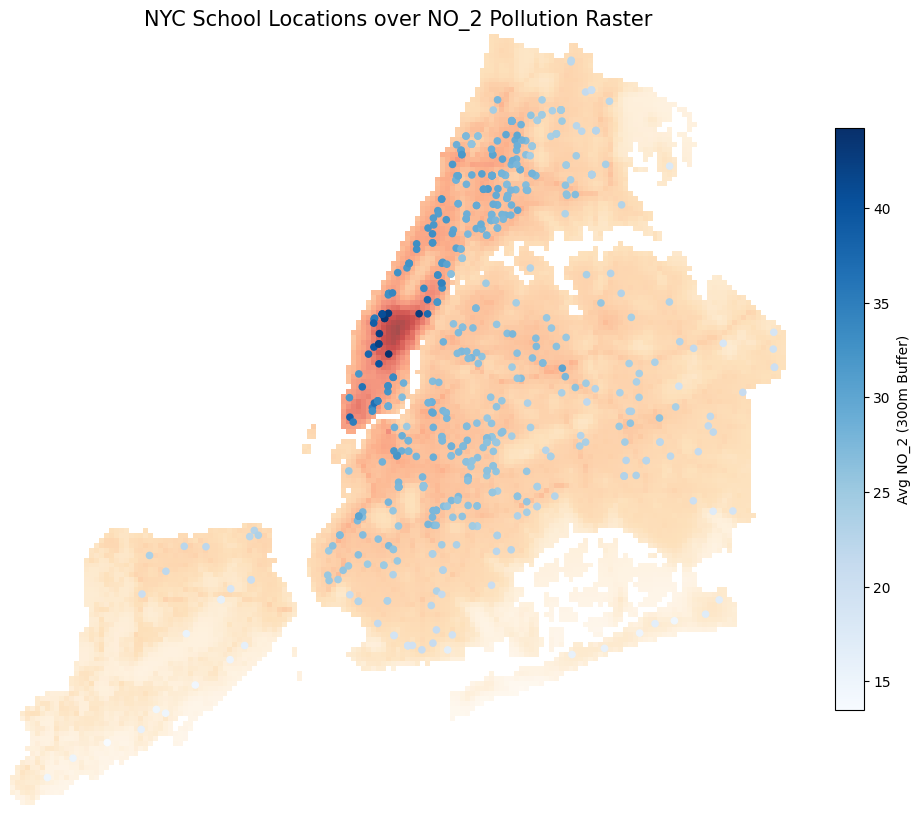

In [5]:
with rasterio.open(raster_path_full) as src:
    fig, ax = plt.subplots(figsize=(10, 10))

    rasterio.plot.show(src, ax=ax, cmap="OrRd", alpha=0.7)

    school_gdf.plot(
        ax=ax,
        column='no2_mean_300m',
        cmap='Blues',
        markersize=20,
        legend=True,
        legend_kwds={'label': "Avg NO_2 (300m Buffer)", 'shrink': 0.6}
    )

    ax.set_title("NYC School Locations over NO_2 Pollution Raster", fontsize=15)
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

The visual clustering of high-exposure schools suggests a spatial correlation between dense urban infrastructure, traffic concentration, and environmental burden. This supports the hypothesis of environmental inequality in school access—students in denser, lower-income areas may be disproportionately exposed to harmful air quality.

Future works:
- If overlaid with socio-demographic data (e.g., income, race, housing), this analysis could help identify environmental justice gaps.
- The findings raise important questions: Are students in more vulnerable communities also the ones exposed to worse air quality? Is school siting policy aligned with public health goals?